# EBAC - Regressão II - regressão múltipla

## Tarefa II

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from patsy import dmatrix
from sklearn.model_selection import train_test_split
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('previsao_de_renda.csv')
df = df.dropna()
df.drop(['Unnamed: 0','data_ref'], axis=1,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_cliente             12427 non-null  int64  
 1   sexo                   12427 non-null  object 
 2   posse_de_veiculo       12427 non-null  bool   
 3   posse_de_imovel        12427 non-null  bool   
 4   qtd_filhos             12427 non-null  int64  
 5   tipo_renda             12427 non-null  object 
 6   educacao               12427 non-null  object 
 7   estado_civil           12427 non-null  object 
 8   tipo_residencia        12427 non-null  object 
 9   idade                  12427 non-null  int64  
 10  tempo_emprego          12427 non-null  float64
 11  qt_pessoas_residencia  12427 non-null  float64
 12  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(5)
memory usage: 1.2+ MB


In [3]:
y = df.loc[:,'renda']
X = df.drop('renda', axis= 1)

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na base de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.
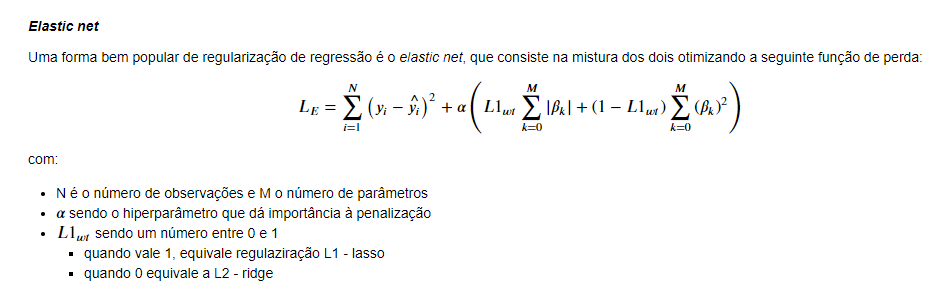

In [4]:
#1.
X_train, X_teste, y_train, y_teste = train_test_split(X,y, test_size=0.25, random_state=42)
X_train

,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia
10766,1874,F,True,True,0,Assalariado,Superior completo,Casado,Casa,50,5.509589,2.0
936,6630,M,False,True,1,Assalariado,Secundário,Casado,Casa,23,1.158904,3.0
695,11933,M,False,False,0,Servidor público,Secundário,Casado,Casa,41,0.578082,2.0
1389,10060,F,True,True,1,Assalariado,Secundário,Casado,Casa,37,11.969863,3.0
1846,14985,F,False,True,0,Assalariado,Secundário,Casado,Casa,56,6.353425,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14422,16293,F,False,True,0,Empresário,Secundário,Casado,Casa,28,0.375342,2.0
6262,14708,F,True,False,1,Assalariado,Secundário,Casado,Casa,50,6.802740,3.0
6497,2638,M,True,True,0,Assalariado,Secundário,União,Casa,29,1.306849,2.0
1036,7702,M,False,True,0,Assalariado,Secundário,Separado,Casa,48,4.180822,1.0


In [16]:
treino = X_train.copy()
treino['renda']= y_train.copy()

In [7]:
#Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  𝑅2
  #na base de testes. Qual o melhor modelo?

modelo = 'np.log(renda) ~ C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) + C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia) + qt_pessoas_residencia + qtd_filhos + tempo_emprego'
alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for n in alpha:
    md = smf.ols(modelo, data=treino)
    reg = md.fit_regularized(method='elastic_net', refit=True, L1_wt=0.001, alpha=n)
    print(f"Resultado para alpha={n}")
    print(reg.summary())


Resultado para alpha=0
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     210.4
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:31:50   Log-Likelihood:                -10204.
No. Observations:                9320   AIC:                         2.046e+04
Df Residuals:                    9296   BIC:                         2.064e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

Resultado para alpha=0.005
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     210.4
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:31:51   Log-Likelihood:                -10204.
No. Observations:                9320   AIC:                         2.046e+04
Df Residuals:                    9296   BIC:                         2.064e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Resultado para alpha=0.05
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     240.4
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:31:52   Log-Likelihood:                -10204.
No. Observations:                9320   AIC:                         2.045e+04
Df Residuals:                    9299   BIC:                         2.061e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [8]:
#Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?

modelo = 'np.log(renda) ~ C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) + C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia) + qt_pessoas_residencia + qtd_filhos + tempo_emprego'

alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

for n in alpha:
    md = smf.ols(modelo, data=treino)
    reg = md.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=n)
    print(f"Resultado para alpha={n}")
    print(reg.summary())


Resultado para alpha=0
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     210.4
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:31:53   Log-Likelihood:                -10204.
No. Observations:                9320   AIC:                         2.046e+04
Df Residuals:                    9296   BIC:                         2.064e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

Resultado para alpha=0.005
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     812.2
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:31:54   Log-Likelihood:                -10265.
No. Observations:                9320   AIC:                         2.054e+04
Df Residuals:                    9314   BIC:                         2.059e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Resultado para alpha=0.1
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     1180.
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:31:54   Log-Likelihood:                -10315.
No. Observations:                9320   AIC:                         2.064e+04
Df Residuals:                    9316   BIC:                         2.068e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

#### Conclusão R²: Lasso x Ridge:

Não houve diferença entre os R² =0,352 e adjR² =0,350 dos diferentes modelos, entretanto quanto maior o alpha mais variáveis foram desconsideradas do modelo com preservação dos valores AIC paralelamente ao aumento do alpha. 

No modelo Lasso com aumento do alpha iniciando em 0 o R² foi de  R²=0,352 e adjR²=0,350 para aproximadamente R²: 0.344(mesmo valor do R² ajustado) entretanto houve aumento do AIC paralelamente ao aumento de alpha. Deste modo podemos concluir que o modelo ridge performou melhor.

7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [9]:
step = pd.get_dummies(df, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)
step =step.rename(columns={'tipo_renda_Servidor público': 'tipo_renda_Servidor_público'})
step =step.rename(columns={'educacao_Pós graduação': 'educacao_Pós_graduação'})
step =step.rename(columns={'educacao_Superior completo': 'educacao_Superior_completo'})
step =step.rename(columns={'educacao_Superior incompleto': 'educacao_Superior_incompleto'})
step =step.rename(columns={'tipo_residencia_Com os pais': 'tipo_residencia_Com_pais'})

step.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id_cliente                     12427 non-null  int64  
 1   qtd_filhos                     12427 non-null  int64  
 2   idade                          12427 non-null  int64  
 3   tempo_emprego                  12427 non-null  float64
 4   qt_pessoas_residencia          12427 non-null  float64
 5   renda                          12427 non-null  float64
 6   sexo_M                         12427 non-null  uint8  
 7   posse_de_veiculo_True          12427 non-null  uint8  
 8   posse_de_imovel_True           12427 non-null  uint8  
 9   tipo_renda_Bolsista            12427 non-null  uint8  
 10  tipo_renda_Empresário          12427 non-null  uint8  
 11  tipo_renda_Pensionista         12427 non-null  uint8  
 12  tipo_renda_Servidor_público    12427 non-null 

In [10]:
y = step.renda
X = step.drop('renda', axis= 1)

In [11]:
X_train, X_teste, y_train, y_teste = train_test_split(X,y, test_size=0.25, random_state=42)
X_train

,id_cliente,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,posse_de_veiculo_True,posse_de_imovel_True,tipo_renda_Bolsista,tipo_renda_Empresário,...,educacao_Superior_incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
10766,1874,0,50,5.509589,2.0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
936,6630,1,23,1.158904,3.0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
695,11933,0,41,0.578082,2.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1389,10060,1,37,11.969863,3.0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1846,14985,0,56,6.353425,2.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14422,16293,0,28,0.375342,2.0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
6262,14708,1,50,6.802740,3.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6497,2638,0,29,1.306849,2.0,1,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1036,7702,0,48,4.180822,1.0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [12]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

variaveis = stepwise_selection(X, y)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 0.0
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 1.75299e-07
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  idade                          with p-value 1.9605e-07
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade']
Add  educacao_Superior_completo     with p-value 3.07164e-06
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo']
Add  qt_pessoas_residencia          with p-value 0.00747762
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'qt_pessoas_residencia']
Add  posse_de_imovel_True           with p-value 0.0138522
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior_completo', 'qt_pessoas_residencia', 'posse_d

In [13]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64') 
        for new_column in excluded:
            print(included+[new_column])
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [14]:
result = stepwise_selection(X, y)

print('resulting features:')
print(result)

['idade']
['tipo_residencia_Estúdio']
['posse_de_veiculo_True']
['estado_civil_Separado']
['tipo_residencia_Casa']
['educacao_Secundário']
['educacao_Pós_graduação']
['tipo_residencia_Comunitário']
['qtd_filhos']
['educacao_Superior_incompleto']
['posse_de_imovel_True']
['tipo_renda_Pensionista']
['tipo_renda_Servidor_público']
['estado_civil_União']
['tipo_residencia_Governamental']
['estado_civil_Solteiro']
['sexo_M']
['estado_civil_Viúvo']
['tipo_renda_Empresário']
['educacao_Superior_completo']
['tipo_residencia_Com_pais']
['qt_pessoas_residencia']
['id_cliente']
['tipo_renda_Bolsista']
['tempo_emprego']
Add                              24 with p-value 0.0
[24]


KeyError: "None of [Int64Index([24], dtype='int64')] are in the [columns]"

In [15]:
reg_stepwise = sm.OLS(y, sm.add_constant(pd.DataFrame(X[variaveis]))).fit()
reg_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     609.1
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:32:04   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12419   BIC:                         2.577e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -3459.8998    423.077     -8.178      0.000   -4289.197   -2630.602
tempo_emprego                554.6452     10.939     50.705      0.000     533.204     576.087
sexo_M                      6081.3827    146.126     41.618      0.000    5794.954    6367.811
tipo_renda_Empresário        800.7100    154.632      5.178      0.000     497.608    1103.812
idade                         47.0834      8.093      5.818      0.000      31.220      62.946
educacao_Superior_completo   657.5362    143.022      4.597      0.000     377.190     937.882
qt_pessoas_residencia        197.4659     76.123      2.594      0.009      48.254     346.678
posse_de_imovel_True         358.0602    145.469      2.461      0.014      72.919     643.202
==============================================================================
Omnibus:                    17576.608   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9917505.257
Skew:                           8.131   Prob(JB):                         0.00
Kurtosis:                     140.437   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""